# Diplomski rad 02
28\. veljače 2017.

In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.debugger import Tracer
import graphviz as gv
import networkx as nx
import pydot
import os
from utility.log_progress import log_progress
from importlib import reload
import utility.functions
reload(utility.functions)
from utility.functions import *
from collections import Counter

matplotlib.rcParams['figure.figsize'] = (12, 8)

sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)


- Konvencija: vremenski nizovi spremljeni su kao vektor-stupci
- **sp500** je matrica s cijenama dionica, **sp500_log** je matrica s logaritmima cijena dionica
- Definicija: **gornje-prizmoidni (3-D) tenzor** je tenzor koji duž prve dimenzije sadrži gornje-trokutaste matrice


## Funkcije
- `rolling_mean_variance(series, T)` računa očekivanje i varijancu nad zadanim podacima (`series`) nad pomičnim prozorom širine `T`
- `flatten_prismatic_tensor(K)` pretvara gornje-prizmoidni 3-D tenzor u 2-D tenzor koji u retcima sadrži izravnate gornje-trokutaste matrice originalnog tenzora
- `encode_pair`
- `encode_pairs`
- `decode_pair`
- `decode_pairs`


## Prikaz primjera distribucije srednjih vrijednosti i varijanci

- **sp500_log_diffs** je izravnati gornje-trokutasti tenzor koji sadrži razlike parova dionica za svaki dan
- **sp500_log_diff_means**, **sp500_log_diff_vars**

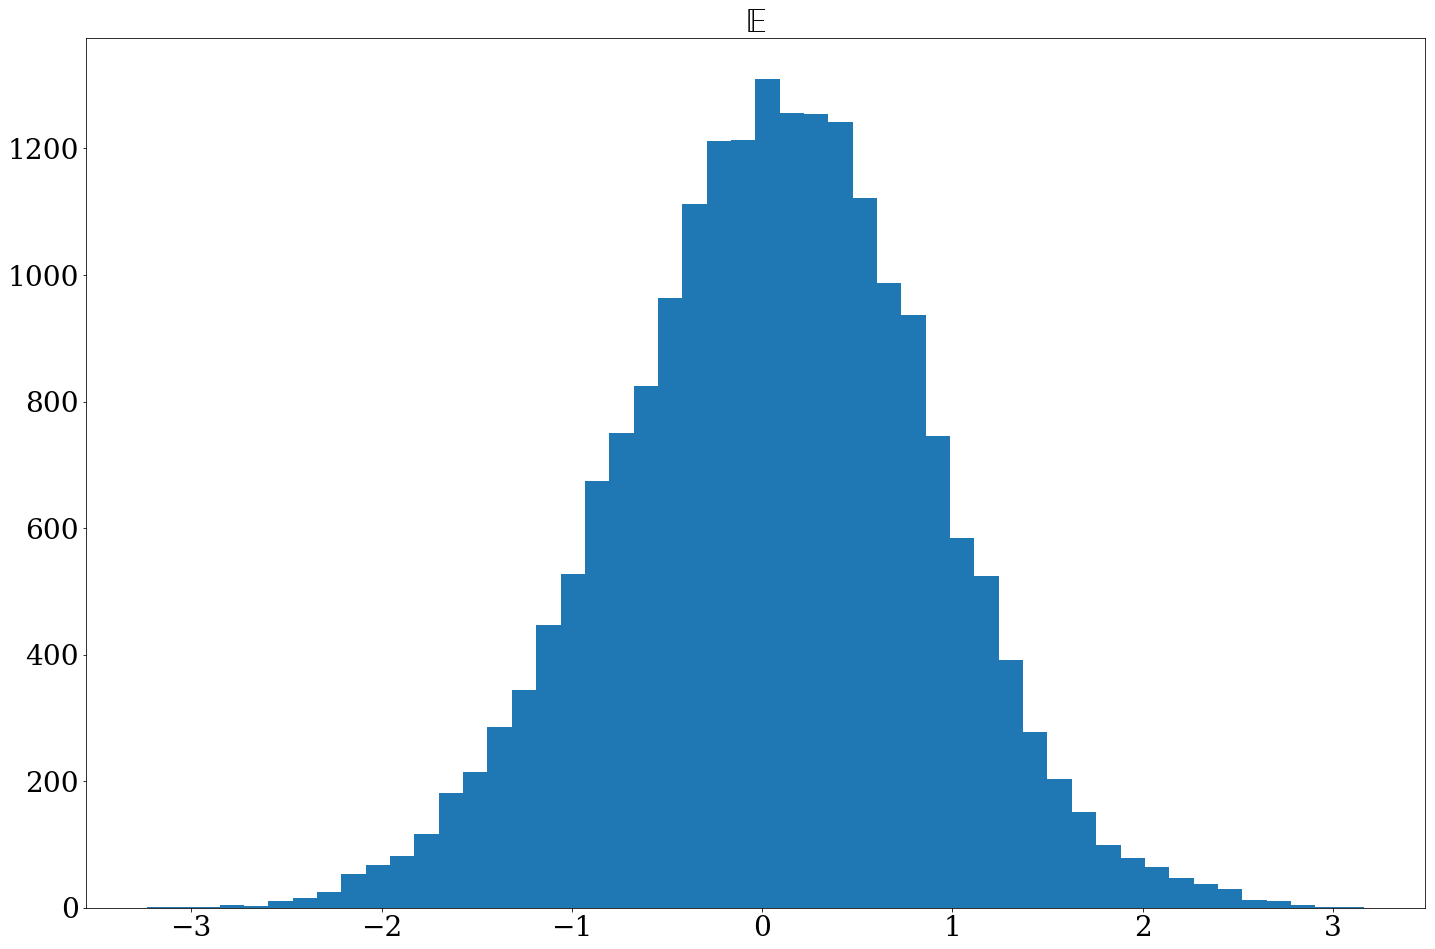

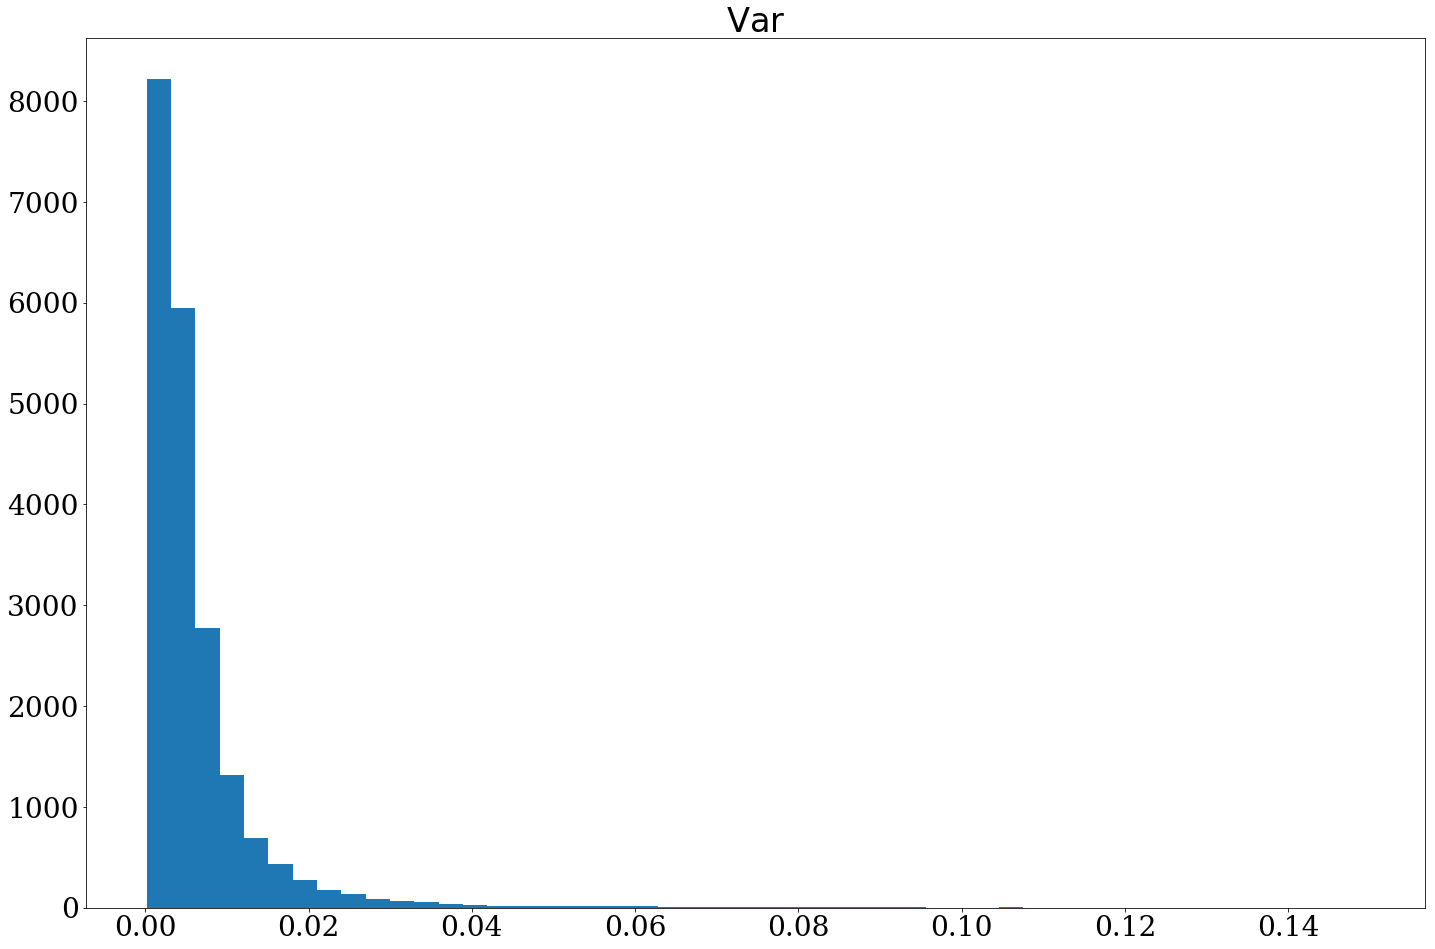

In [92]:
T = 120

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

plt.figure()
plt.hist(sp500_log_diff_means[4321, :], 50)
plt.title('$\\mathrm{\\mathbb{E}}$')
plt.figure()
plt.hist(sp500_log_diff_vars[4321, :], 50);
plt.title('$\\mathrm{Var}$');


## Prikaz parova dionica s najmanjim i najvećim varijancama

### Pobjednici

In [6]:
T = 120
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)        
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
sp500_log_diff_stds = np.sqrt(sp500_log_diff_vars)

days, N = sp500.shape
pairs = N * (N - 1) // 2

In [7]:
codes = sorted(list(range(pairs)), key=lambda c: sp500_log_diff_vars[4321, c])
sorted_vars = sorted(sp500_log_diff_vars[4321, :])
best = decode_pairs(codes[:5], N)
worst = decode_pairs(codes[-5:], N)

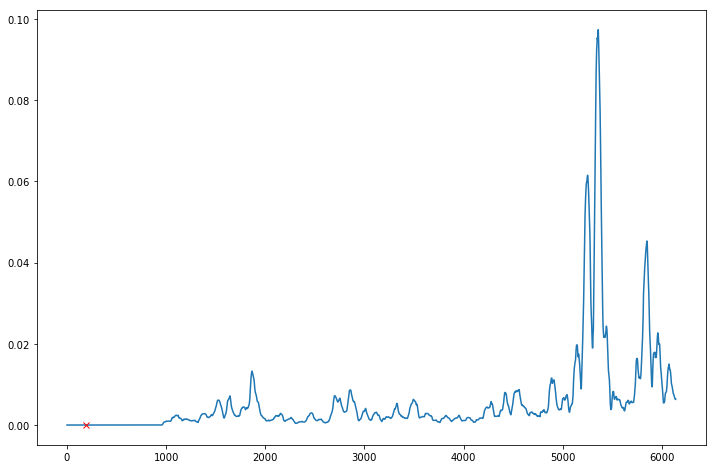

In [8]:
min_vars = np.min(sp500_log_diff_vars, axis=1)
t_min_var = np.argmin(min_vars)
pair_min_var = np.argmin(sp500_log_diff_vars[t_min_var], axis=0)

plt.plot(sp500_log_diff_vars[:, pair_min_var])
plt.plot([t_min_var], [sp500_log_diff_vars[t_min_var, pair_min_var]], 'rx');

# plt.plot(np.min(sp500_log_diff_vars, axis=1))

### Gubitnici

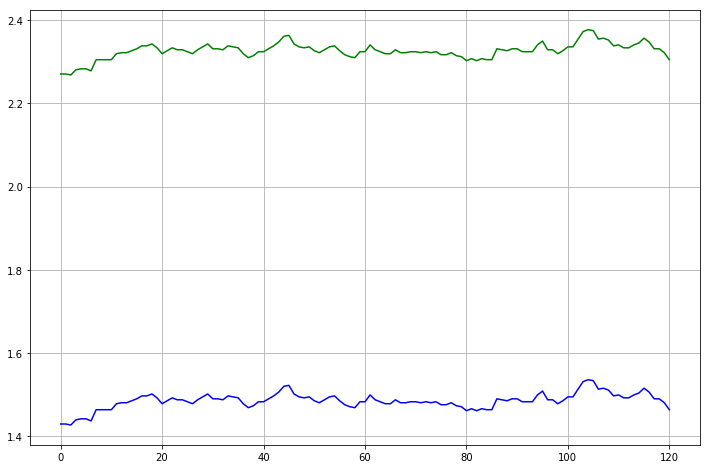

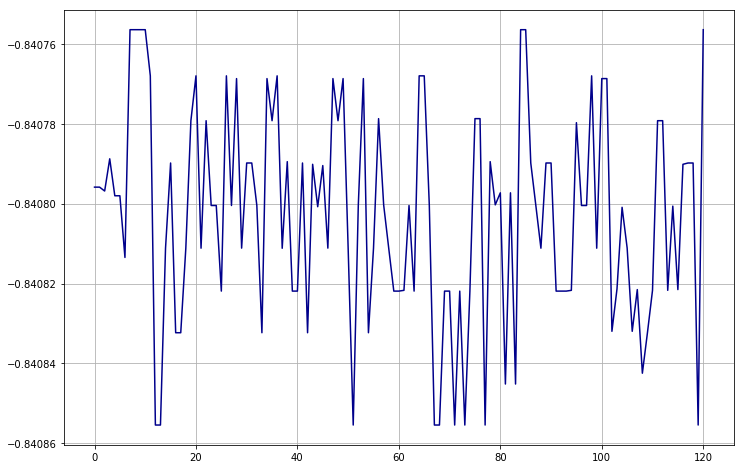

In [9]:
# for (i, j), var in zip(best, sorted_vars[:5]):
#     plt.figure()
#     plt.plot(sp500_log[4321:4321 + T, i - 1], 'b')
#     plt.plot(sp500_log[4321:4321 + T, j - 1], 'g')
# #     plt.legend((i, j), loc='best')
#     plt.autoscale(enable=True, axis='x', tight=True)
# #     plt.title('$\\mathrm{{Var}}={:.5e}$'.format(var))
#     plt.grid()

plt.figure()
i, j = decode_pair(pair_min_var, N)
plt.plot(sp500_log[t_min_var - T:t_min_var + 1, i - 1], 'b')
plt.plot(sp500_log[t_min_var - T:t_min_var + 1, j - 1], 'g')
plt.grid()
plt.figure()
plt.plot(sp500_log[t_min_var - T:t_min_var + 1, i - 1] - sp500_log[t_min_var - T:t_min_var + 1, j - 1], 'darkblue')
plt.grid()


## Rasponi vrijednosti za parove s najmanjim varijancama

- **plavo:** dvije devijacije
- **zeleno:** polovica maksimalnog odstupanja

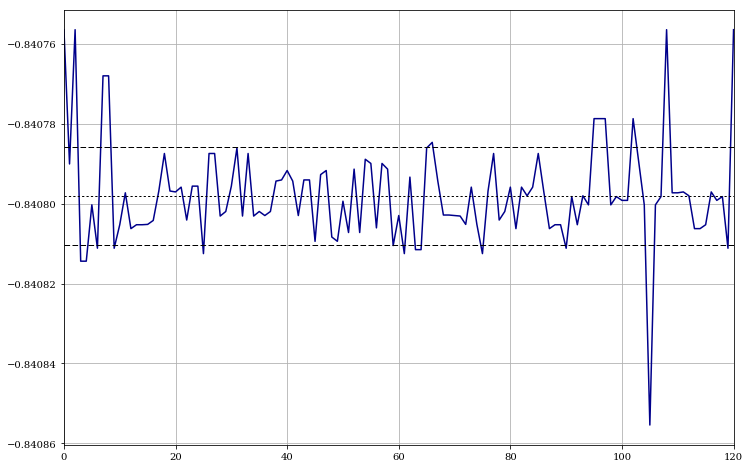

In [98]:
T = 120
plt.figure()
c = pair_min_var
lower = sp500_log_diff_means[t_min_var, c] - np.sqrt(sp500_log_diff_vars[t_min_var, c])
upper = sp500_log_diff_means[t_min_var, c] + np.sqrt(sp500_log_diff_vars[t_min_var, c])
plt.plot(sp500_log_diffs[t_min_var:t_min_var + T + 1, c], ls='-', c='darkblue')
plt.plot([0, T], [sp500_log_diff_means[t_min_var, c], sp500_log_diff_means[t_min_var, c]], 'k:', lw=1)
plt.plot([0, T], [lower, lower], 'k--', lw=1)
plt.plot([0, T], [upper, upper], 'k--', lw=1)
plt.gca().set_xlim([0, 120])
plt.grid()
plt.savefig('deviation-magnitude.svg', bbox_inches='tight')


# Statistička arbitraža

## Testiranje implementacije nad trivijalnim podacima

In [11]:
trading_signal = (sp500_log_diffs[T:] - sp500_log_diff_means[:-1]) / sp500_log_diff_stds[:-1]

0.088906544133


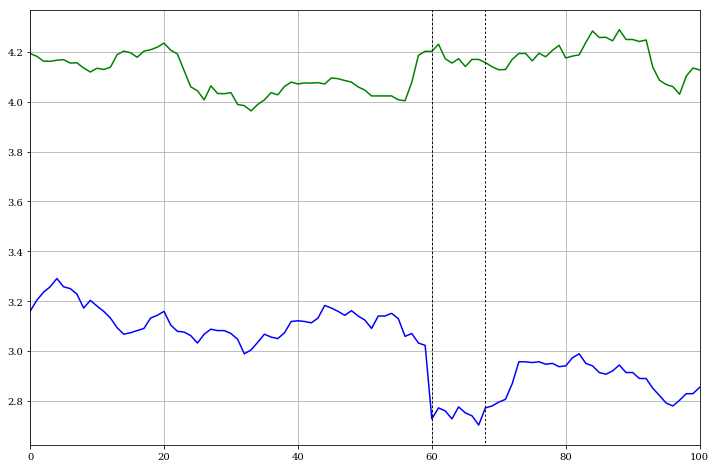

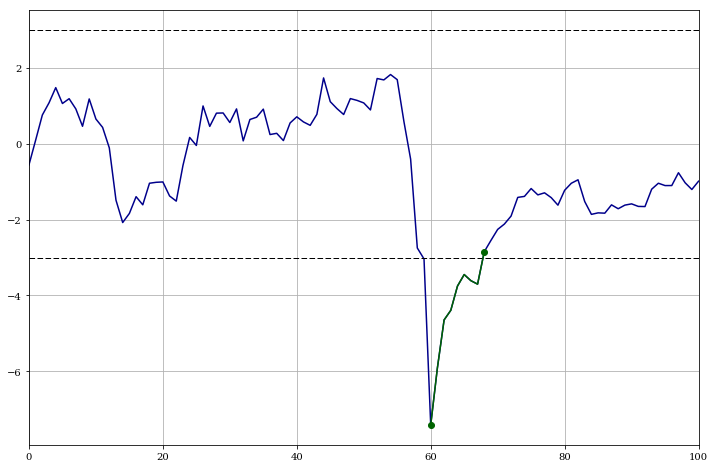

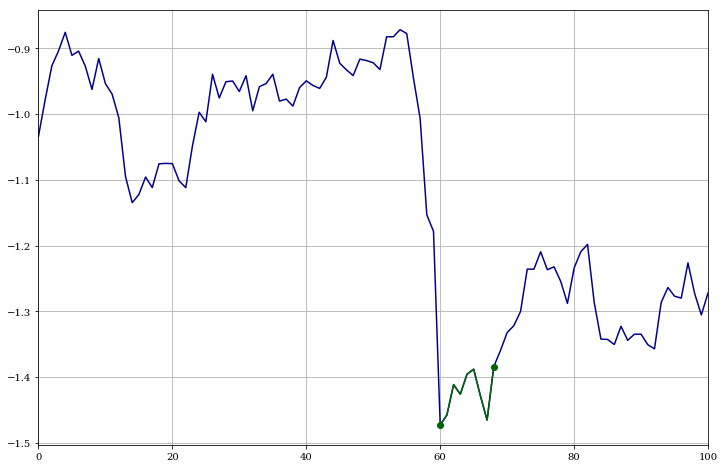

In [99]:
t_max_trading = np.argsort(np.max(trading_signal, axis=1))[-100]
p_max_trading = np.argsort(trading_signal[t_max_trading])[0]

plt.figure()
i, j = decode_pair(p_max_trading, N)
plt.plot(sp500_log[t_max_trading + T // 2:t_max_trading + T + 1 + 40, i - 1], 'b')
plt.plot(sp500_log[t_max_trading + T // 2:t_max_trading + T + 1 + 40, j - 1], 'g')
lim = plt.gca().get_ylim()
plt.plot([120 - T // 2, 120 - T // 2], [0, 5], 'k:', linewidth=1)
plt.plot([128 - T // 2, 128 - T // 2], [0, 5], 'k:', linewidth=1)
plt.gca().set_ylim(lim)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('trading-signal.svg', bbox_inches='tight')

plt.figure()
plt.plot(trading_signal[t_max_trading - T // 2:t_max_trading + 1 + 40, p_max_trading], 'darkblue')
plt.plot([0, 100], [3.0, 3.0], 'k--', linewidth=1)
plt.plot([0, 100], [-3.0, -3.0], 'k--', linewidth=1)
plt.plot(np.arange(120 - T // 2, 129 - T // 2).reshape([-1, 1]), trading_signal[t_max_trading - T + 120:t_max_trading - T + 129, p_max_trading], 'darkgreen')
lim = plt.gca().get_ylim()
# plt.plot([120 - T // 2, 120 - T // 2], [-10, 10], 'k:', linewidth=1)
# plt.plot([128 - T // 2, 128 - T // 2], [-10, 10], 'k:', linewidth=1)
plt.plot([120 - T // 2, 128 - T // 2], [trading_signal[t_max_trading - T + 120, p_max_trading], trading_signal[t_max_trading - T + 128, p_max_trading]], 'darkgreen', marker='o', ls='')
# plt.plot([118, 118], [-10, 10], 'k:', linewidth=1)
# plt.plot([129, 129], [-10, 10], 'k:', linewidth=1)
plt.gca().set_ylim(lim)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('trading-prices.svg', bbox_inches='tight')

plt.figure()
plt.plot(sp500_log_diffs[t_max_trading + T // 2:t_max_trading + T + 1 + 40, p_max_trading], 'darkblue')
lim = plt.gca().get_ylim()
# plt.plot([120 - T // 2, 120 - T // 2], [-5, 5], 'k:', linewidth=1)
# plt.plot([128 - T // 2, 128 - T // 2], [-5, 5], 'k:', linewidth=1)
plt.plot([120 - T // 2, 128 - T // 2], [sp500_log_diffs[t_max_trading + 120, p_max_trading], sp500_log_diffs[t_max_trading + 128, p_max_trading]], 'darkgreen', marker='o', ls='')
plt.plot(np.arange(120 - T // 2, 129 - T // 2).reshape([-1, 1]), sp500_log_diffs[t_max_trading + 120:t_max_trading + 129, p_max_trading], 'darkgreen')
plt.gca().set_ylim(lim)
# plt.axes().arrow(70, -1.45, 0, 0.1, head_width=1, head_length=0.1, fc='k', ec='k')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('trading-diffs.svg', bbox_inches='tight')

print(-sp500_log_diffs[t_max_trading + 120, p_max_trading] + sp500_log_diffs[t_max_trading + 128, p_max_trading])

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]]
[[ 1. ]
 [ 1.2]
 [ 1.2]
 [ 1.2]
 [ 1.2]
 [ 1.2]
 [ 1. ]
 [ 0.8]
 [ 0.8]]
[[ 0. ]
 [ 0.2]
 [ 0.2]
 [ 0.2]
 [ 0.2]
 [ 0.2]
 [ 0. ]
 [ 0.2]
 [ 0.2]]
[ 5 11]
[ 0.5  0.5]
[ 0.78885438  0.78885438]


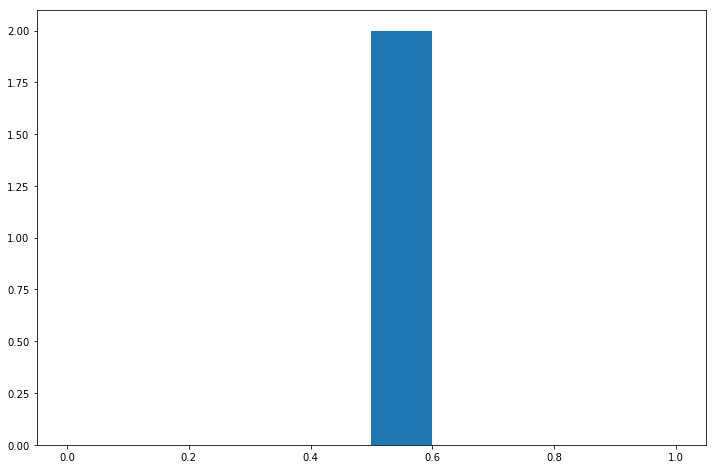

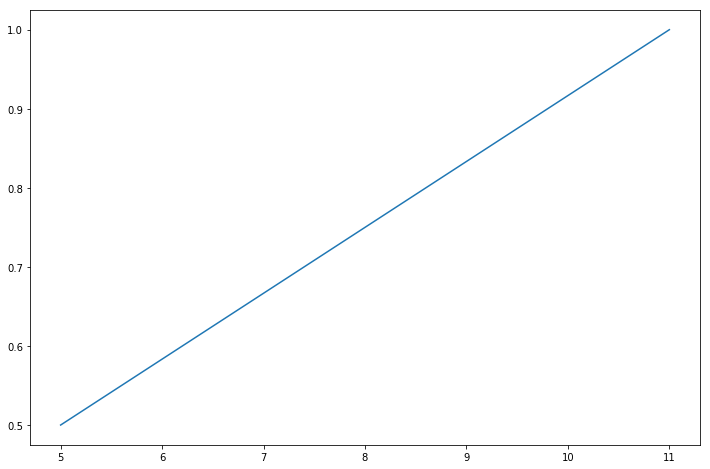

In [173]:
my_prices_logs = np.array([
        [2, 2, 2, 2, 2, 2.5, 2, 2, 2, 2, 2, 1.5, 2],
        [1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1.5, 1],
        #[1, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1, 1.5, 1],
        #[1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1]
        ]).transpose();

my_prices_diffs = calculate_pairwise_diffs(my_prices_logs)
my_prices_means, my_prices_vars = rolling_mean_variance(my_prices_diffs, 5)

ts, profit, pairs, weights = statistical_arbitrage(my_prices_diffs, my_prices_means, my_prices_vars,
                                                   1, 1, method='thresh-devs',
                                                   return_pairs=True, return_weights=True)

print(my_prices_diffs)
print(my_prices_means)
print(my_prices_vars)
print(ts)
print(profit)
print(weights)

plt.figure()
plt.hist(profit)
plt.figure()
plt.plot(ts, np.cumsum(profit));

## Variranje parametara p i d

### Metoda s fiksnim brojem parova p

p = 1, d = 1, profit = 1.0610121286665337, acc = 0.5428994082840237
p = 1, d = 1.5, profit = 0.7524311550212819, acc = 0.5393824826717076
p = 1, d = 2, profit = 0.39900758997399666, acc = 0.5208333333333334
p = 1, d = 2.5, profit = 0.3046186015529156, acc = 0.5539568345323741
p = 1, d = 3, profit = 0.12478262692667419, acc = 0.5643564356435643
p = 1, d = 3.5, profit = 0.11340420631127635, acc = 0.5471698113207547
p = 1, d = 4, profit = 0.0005595687792867565, acc = 0.5178571428571429
p = 1, d = 4.5, profit = 0.04341373415167338, acc = 0.5238095238095238
p = 1, d = 5, profit = 0.04097831626507231, acc = 0.5666666666666667
p = 2, d = 1, profit = 1.5990713742387257, acc = 0.5182857142857142
p = 2, d = 1.5, profit = 1.227301512725058, acc = 0.5210312075983717
p = 2, d = 2, profit = 0.6243982295042965, acc = 0.5114693118412895
p = 2, d = 2.5, profit = 0.613079973651388, acc = 0.5373891001267427
p = 2, d = 3, profit = 0.26021970256714333, acc = 0.5347593582887701
p = 2, d = 3.5, profit = 0.23

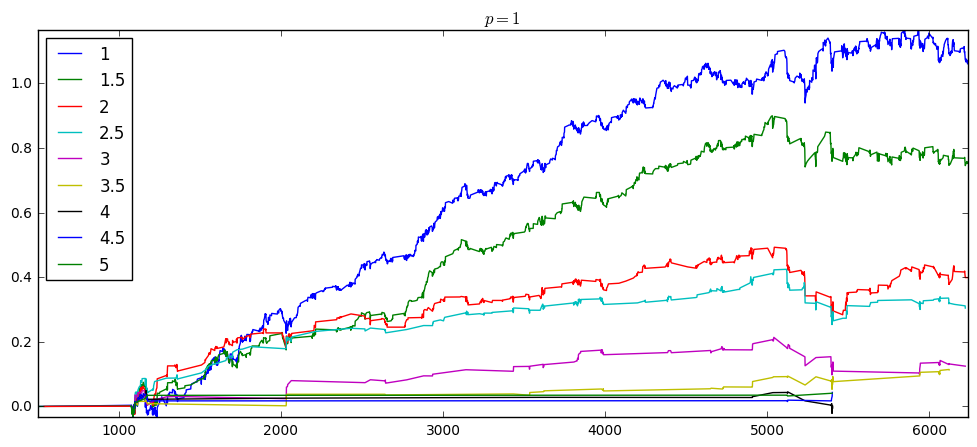

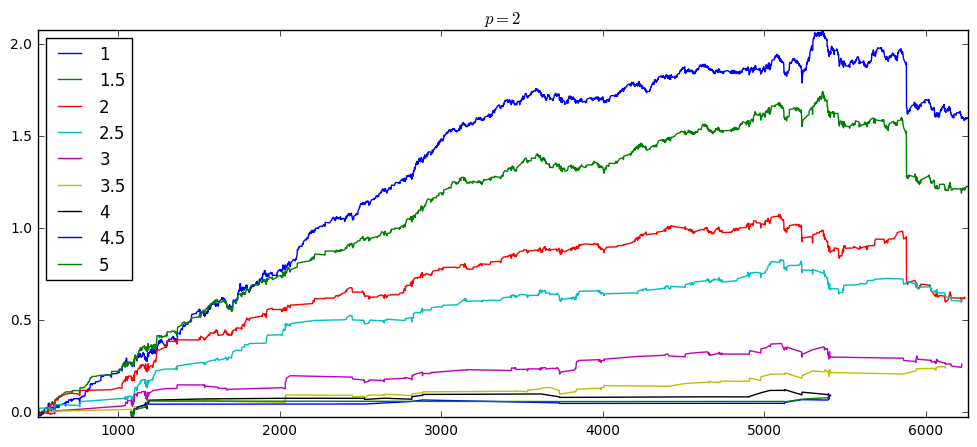

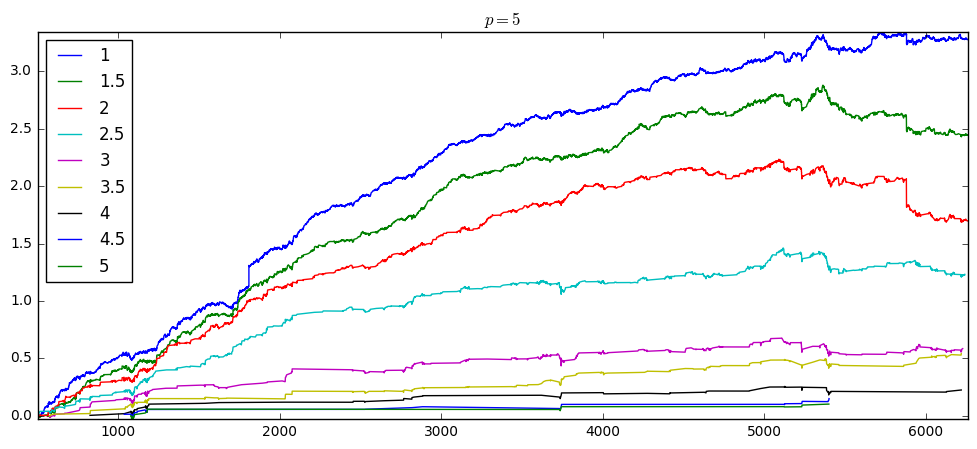

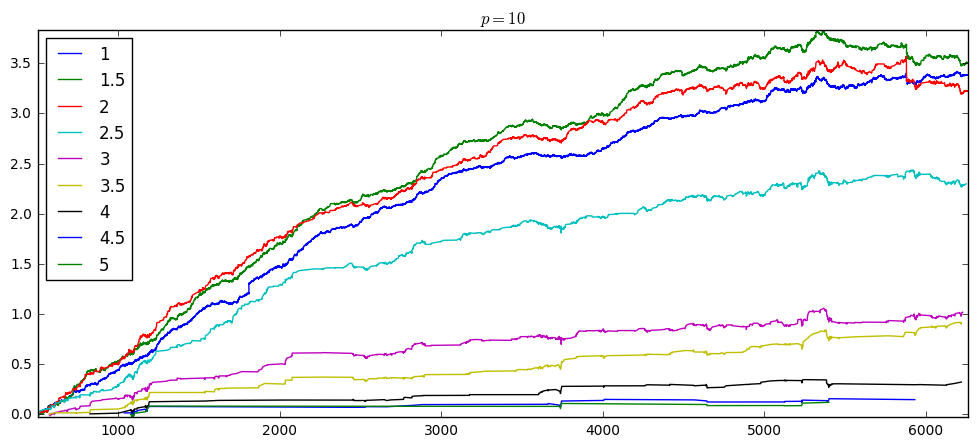

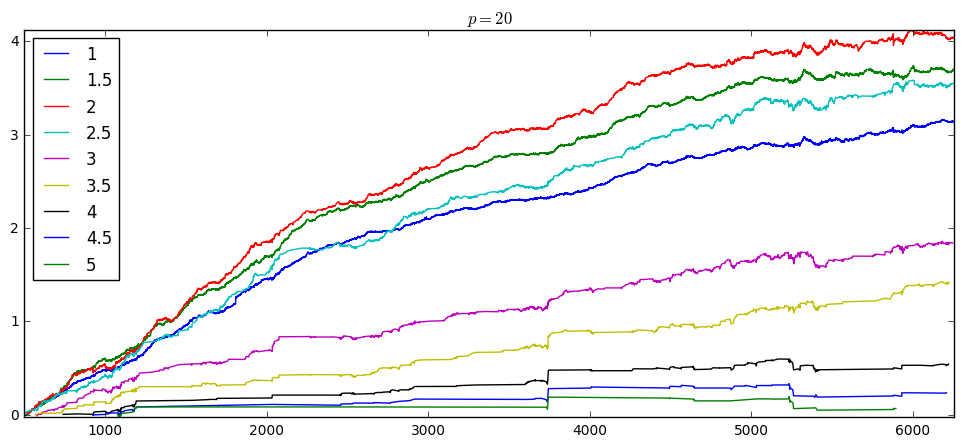

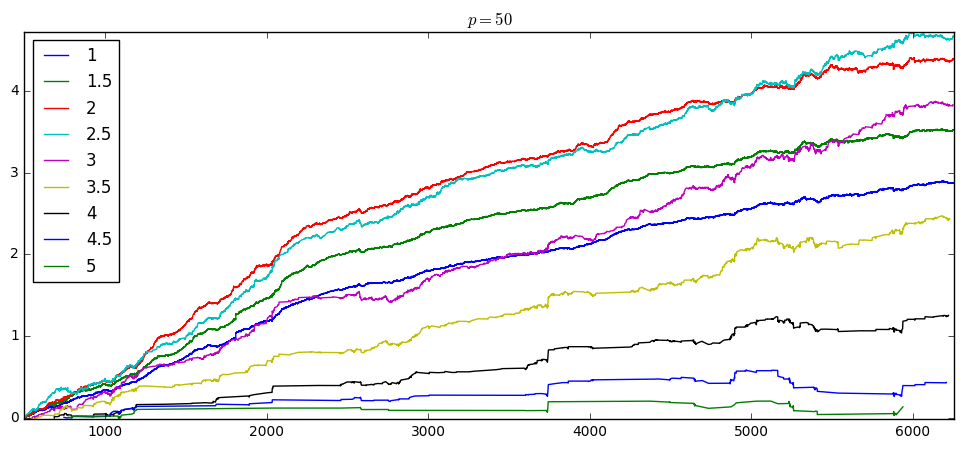

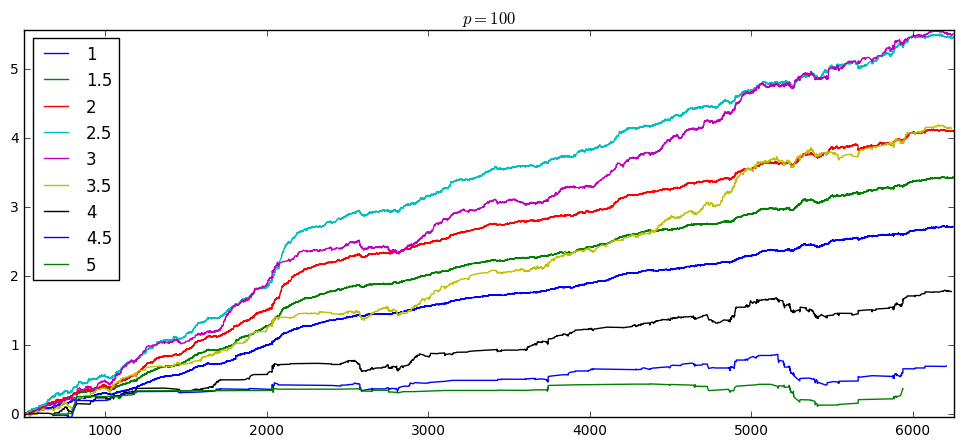

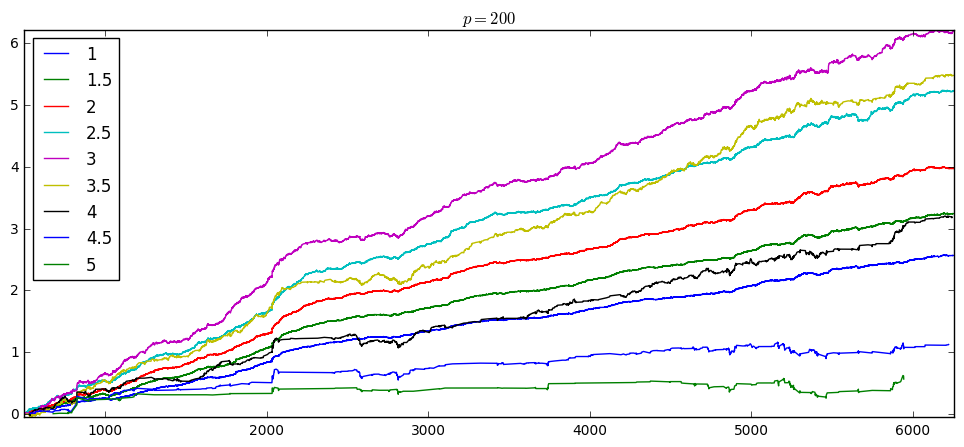

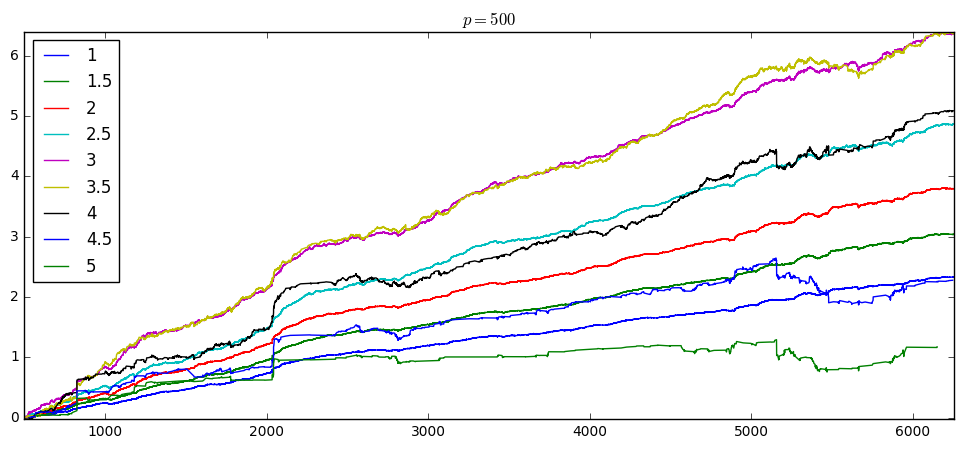

In [7]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

T = 500
ps = [1, 2, 5, 10, 20, 50, 100, 200, 500]
ds = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

for p in ps:
    plt.figure()
    plt.title('$p={}$'.format(p))
    for d in ds:
        ts, profit = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                           p, d, method='devs')

        plt.plot(ts, np.cumsum(profit))
        plt.autoscale(enable=True, axis='x', tight=True)
        print('p = {}, d = {}, profit = {}, acc = {}'.format(p, d, np.sum(profit), np.sum(profit > 0) / len(profit)))
    plt.legend([str(d) for d in ds], loc='best')

del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)


### Metoda s fiksnim pragom varijacije

In [ ]:
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
sp500 = sp500
sp500_log = np.log(sp500)
days, N = sp500.shape
pairs = int(N * (N - 1) / 2)

T = 60
ps = [None]
ds = [3.75]

sp500_log_diffs = calculate_pairwise_diffs(sp500_log)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

p = None, d = 3.75, profit = 13.86750556126341, acc = 0.5824591573516767
avg: 0.6081193324371745, std: 0.30713599668558117, Sharpe: 1.979967633229633
turnover: 1.183912590958544
turnover: 1.1927947538615156
actual profit: 0.04695235113476315


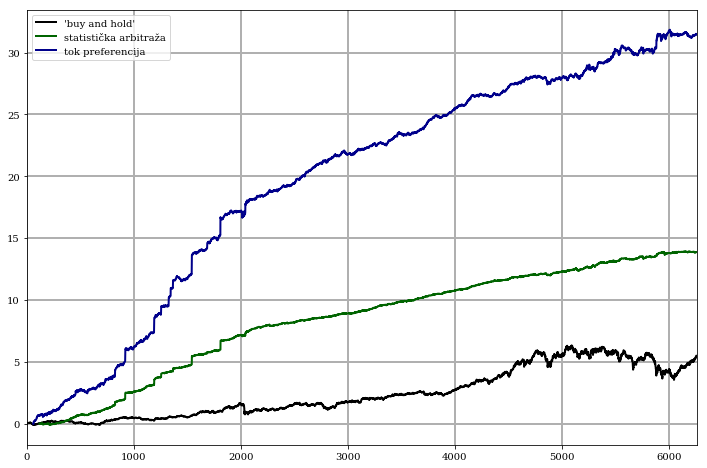

In [105]:
profit1 = np.load('data/profit1.npy')
for p in ps:
    plt.figure()
#     plt.title('$p={}$'.format(p))
    for d in ds:
        ts, profit, pairs = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars,
                                                  p, d, method='thresh-devs', return_pairs=True)
        
        ts0, profit0 = join_ts_profit(ts, profit)
        
        sp500_sum = np.mean(sp500, axis=1)
        plt.plot(sp500_sum / sp500_sum[0] - 1, 'k', linewidth=2)
        plt.plot(ts, np.cumsum(profit), 'darkgreen', linewidth=2)
        plt.plot(range(59, 6260), np.cumsum(profit1), 'darkblue', linewidth=2)
        plt.autoscale(enable=True, axis='x', tight=True)
        print('p = {}, d = {}, profit = {}, acc = {}'.format(p, d, np.sum(profit0),
                                                             np.sum(profit0 > 0) / len(profit0)))
        avg = np.mean(profit0) * 255
        std = np.std(profit0) * np.sqrt(255)
        ppairs = partition_as(ts, pairs)
        pairs1 = []
        pairs2 = []
        for t, p in ppairs:
            p1, p2 = p.T
            pairs1 += [set(p1)]
            pairs2 += [set(p2)]
        turnover1 = turnover_ratio(pairs1)
        turnover2 = turnover_ratio(pairs2)
        print('avg: {}, std: {}, Sharpe: {}'.format(avg, std, avg / std))
        print('turnover: {}'.format(np.mean(turnover1)))
        print('turnover: {}'.format(np.mean(turnover2)))
        print('actual profit: {}'.format(np.sum(profit) - np.sum(np.hstack([turnover1, turnover2])) * 1e-3))
        
    plt.legend(['\'buy and hold\'', 'statistička arbitraža', 'tok preferencija'], loc='best')
    plt.grid(linewidth=2)

# Grafovi

In [ ]:
for v in ["sp500_log_diffs", "sp500_log_diff_means", "sp500_log_diff_vars", "sp500", "sp500_log"]:
    try:
        del globals()[v]
    except:
        pass

sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
# sp500 = sp500[:2000, :]
days, N = sp500.shape
sp500_log = np.log(sp500)
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

T = 120
p = 0.000
d = 3.75

method = 'thresh-devs'

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)

ts, profits_old, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, 
                                                        sp500_log_diff_vars, p, d, 
                                                        method=method, return_pairs=True, 
                                                        return_weights=True)



In [3]:
ppairs = partition_as(ts, pairs, weights)
try:
    os.mkdir('../graphs/p_{}_d_{}_{}'.format(p, d, method))
except:
    pass
for t, ppair, weight in ppairs:
    graph = nx.DiGraph()
    graph.add_edges_from(ppair, weight=weight)
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos)
    labels = nx.get_node_attributes(graph, 'labels')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    dot = nx.drawing.nx_pydot.to_pydot(graph)
    
    dot.write_svg('../graphs/p_{}_d_{}_{}/output_{:04d}.svg'.format(p, d, method, t), prog='sfdp')
    
    preferences = calculate_preference_flow(ppair, weights)
    for n in dot.get_node_list():
        n.set_label('{:.3f}'.format(preferences[int(n.get_name())]))
    dot.write_svg('../graphs/p_{}_d_{}_{}/output_{:04d}_f.svg'.format(p, d, method, t), prog='sfdp')
    try:
        nx.find_cycle(graph, orientation='original')
    except:
        pass
    else:
        print('Cycle detected @ t={}'.format(t))
        
    try:
        nx.find_cycle(graph, orientation='reverse')
    except:
        pass
    else:
        print('Cycle detected @ t={}'.format(t))


NameError: name 'ts' is not defined

In [11]:
calculate_preference_flow([('A', 'B'), ('D', 'B'), ('C', 'B'), ('E', 'F'), ('F', 'B')], scale=True)

{'A': 1.0, 'B': -4.0, 'C': 1.0, 'D': 1.0, 'E': 1.0, 'F': 0.0}

accuracy: 0.48022001269304


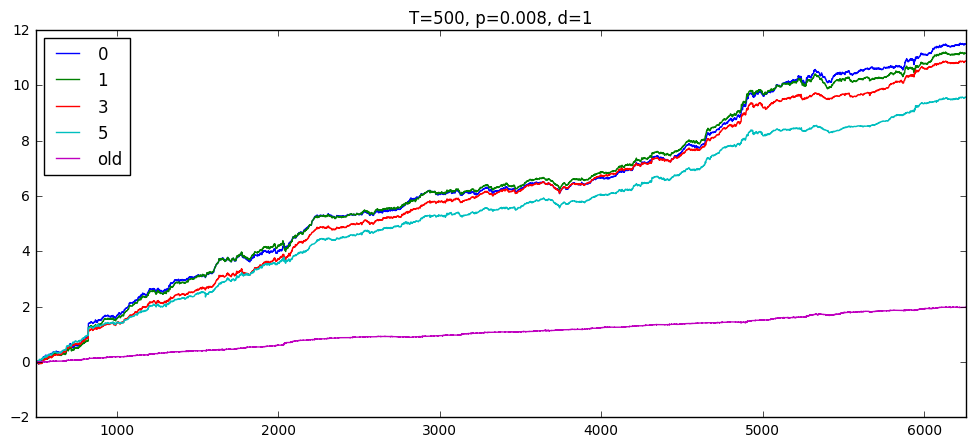

In [12]:
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
sp500 = sp500
sp500_log = np.log(sp500)
days, N = sp500.shape
P = int(N * (N - 1) / 2)

T = 60
# sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

ls = [0]
for l in ls:
    ppairs = partition_as(ts, pairs)
    profit = []
    cumprofit = []
    # abscumprofit = []
    tss = []
    for t, ppair in log_progress(list(ppairs)):
        preferences = calculate_preference_flow(ppair, scale=True)
        m = max(np.abs(list(preferences.values())))
        # n = min(preferences.values())
        # psize = len(preferences)
        tops = np.array([k for k, v in preferences.items() if v >= m - l])
        bottoms = np.array([k for k, v in preferences.items() if -m + l >= v])
        # code = encode_pair(top, bottom, N)
        # p = trade_pair(sp500_log_diffs, t, code, top > bottom)
        p = []
        ttops = np.array([t] * len(tops))
        tbottoms = np.array([t] * len(bottoms))
        if (len(tops) != 0):
            p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        if (len(bottoms) != 0):
            p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        profit.extend([p_ / len(p) for p_ in p])
        cumprofit.append(np.sum(profit))
        # abscumprofit.append(np.sum(np.abs(profit)))
        tss.append(t)

    tss = np.array(tss)
    plt.plot(tss, cumprofit)
    
plt.plot(ts, np.cumsum(profits_old))
#plt.plot(tss, abscumprofit)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(ls + ['old'], loc='best')
plt.title('T={}, p={}, d={}'.format(T, 0.008, d))
print('accuracy: {}'.format(np.sum(np.array(profit) > 0) / len(profit)))

accuracy: 0.5113561769725614


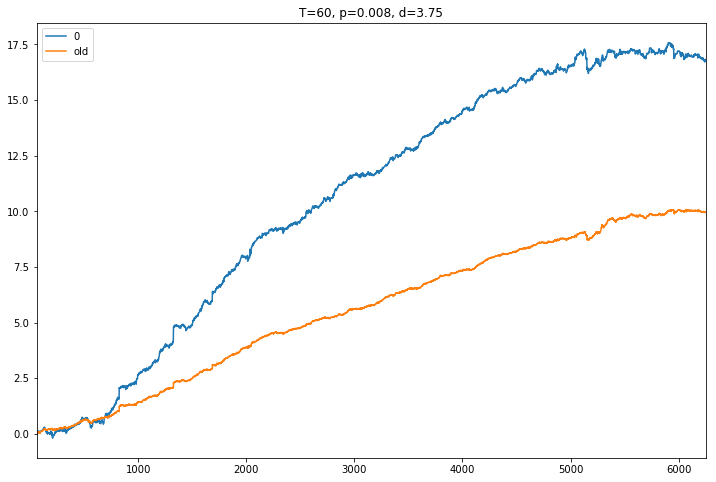

In [45]:
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
# sp500 = sp500[:2000, :]
days, N = sp500.shape
sp500_log = np.log(sp500)
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

T = 60
p = 0.008
d = 3.75

method = 'thresh-devs'

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
del(sp500, sp500_log)

ts, profits_old, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, 
                                                        sp500_log_diff_vars, p, d, 
                                                        method=method, return_pairs=True, 
                                                        return_weights=True)
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
P = int(N * (N - 1) / 2)

T = 60
# sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

ls = [0]
for l in ls:
    ppairs = partition_as(ts, pairs)
    profit = []
    cumprofit = []
    # abscumprofit = []
    tss = []
    for t, ppair in log_progress(list(ppairs)):
        preferences = calculate_preference_flow(ppair, scale=True)
        m = max(np.abs(list(preferences.values())))
        # n = min(preferences.values())
        # psize = len(preferences)
        tops = np.array([k for k, v in preferences.items() if v >= m - l])
        bottoms = np.array([k for k, v in preferences.items() if -m + l >= v])
        # code = encode_pair(top, bottom, N)
        # p = trade_pair(sp500_log_diffs, t, code, top > bottom)
        p = []
        ttops = np.array([t] * len(tops))
        tbottoms = np.array([t] * len(bottoms))
        if (len(tops) != 0):
            p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        if (len(bottoms) != 0):
            p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        profit.extend([p_ / len(p) for p_ in p])
        cumprofit.append(np.sum(profit))
        # abscumprofit.append(np.sum(np.abs(profit)))
        tss.append(t)

    tss = np.array(tss)
    plt.plot(tss, cumprofit)
    
plt.plot(ts, np.cumsum(profits_old))
#plt.plot(tss, abscumprofit)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(ls + ['old'], loc='best')
# plt.title('T={}, p={}, d={}'.format(T, 0.008, d))
print('accuracy: {}'.format(np.sum(np.array(profit) > 0) / len(profit)))

In [14]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
days, N = sp500.shape
sp500_log = np.log(sp500)
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

T = 500
p = 0.008
d = 3

method = 'thresh-devs'

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
del(sp500, sp500_log)

ts, profits_old, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, 
                                                        sp500_log_diff_vars, p, d, 
                                                        method=method, return_pairs=True, 
                                                        return_weights=True)
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
P = int(N * (N - 1) / 2)

T = 500

ppairs = partition_as(ts, pairs)
profit = []
shares = []
ts = []
print('starting arbitrage...')
for t, ppair in log_progress(list(ppairs)):
    preferences = calculate_preference_flow(ppair, scale=True)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m])
    bottoms = np.array([k for k, v in preferences.items() if -m >= v])
    p = []
    if (len(tops) != 0):
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts.extend(ttops)
    if (len(bottoms) != 0):
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts.extend(tbottoms)
    profit.extend([p_ / len(p) for p_ in p])

shares = np.array(shares)
ts = np.array(ts)
profit = np.array(profit)

starting arbitrage...


<Container object of 198 artists>

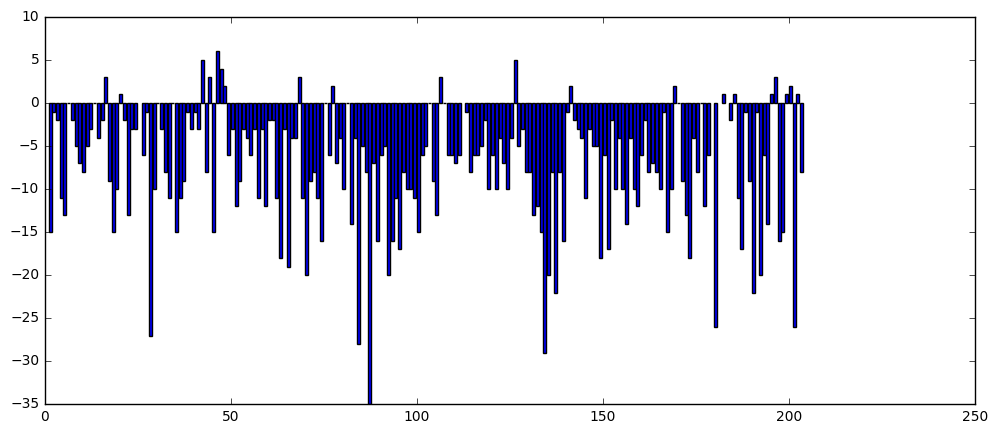

In [15]:
neg_shares = shares[profit < 0]
ts_neg_shares = ts[profit < 0]
pos_shares = shares[profit >= 0]
ts_pos_shares = ts[profit >= 0]

cnt = Counter(neg_shares)
cnt.subtract(Counter(pos_shares))
plt.bar(cnt.keys(), cnt.values())


/home/frka/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "Best". Falling back on "best"; valid locations are
	lower left
	center right
	best
	center left
	upper left
	right
	center
	upper right
	lower center
	lower right
	upper center

  six.iterkeys(self.codes))))


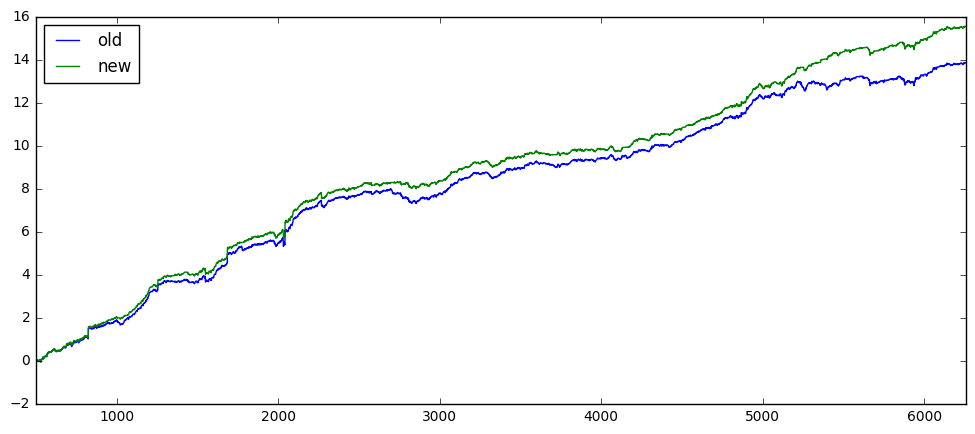

In [17]:
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
days, N = sp500.shape
sp500_log = np.log(sp500)
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

T = 500
p = 0.008
d = 3

method = 'thresh-devs'

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
del(sp500, sp500_log)

ts, profits_old, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, 
                                                        sp500_log_diff_vars, p, d, 
                                                        method=method, return_pairs=True, 
                                                        return_weights=True)
del(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars)
sp500 = np.genfromtxt('../data/stock_prices_sp500.csv', delimiter=',')
sp500_log = np.log(sp500)
days, N = sp500.shape
P = int(N * (N - 1) / 2)

T = 500

ppairs = partition_as(ts, pairs)
profit = []
cumprofit = []
shares = []
ts_shares = []
tss = []
for t, ppair in log_progress(list(ppairs)):
    preferences = calculate_preference_flow(ppair, scale=True)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m])
    bottoms = np.array([k for k, v in preferences.items() if -m >= v])
    p = []
    if (len(tops) != 0):
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts_shares.extend(ttops)
    if (len(bottoms) != 0):
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_shares.extend(tbottoms)
    profit.extend([p_ / len(p) for p_ in p])
    cumprofit.append(np.sum([p_ / len(p) for p_ in p]))
    tss.append(t)
    
plt.plot(tss, np.cumsum(cumprofit))

shares = np.array(shares)
ts_shares = np.array(ts_shares)
profit = np.array(profit)
neg_shares = shares[profit < 0]
ts_neg_shares = ts_shares[profit < 0]
pos_shares = shares[profit >= 0]
ts_pos_shares = ts_shares[profit >= 0]

cnt = Counter(neg_shares)
cnt.subtract(Counter(pos_shares))

blacklist = [k for k, v in cnt.items() if v >= -1]

ppairs = partition_as(ts, pairs)
profit = []
cumprofit = []
tss = []
for t, ppair in log_progress(list(ppairs)):
    preferences = calculate_preference_flow(ppair, scale=True)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m and k not in blacklist])
    bottoms = np.array([k for k, v in preferences.items() if -m >= v and k not in blacklist])
    p = []
    if (len(tops) != 0):
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
    if (len(bottoms) != 0):
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
    profit.extend([p_ / len(p) for p_ in p])
    cumprofit.append(np.sum([p_ / len(p) for p_ in p]))
    tss.append(t)

plt.plot(tss, np.cumsum(cumprofit))
plt.legend(['old', 'new'], loc='best')
plt.autoscale(enable=True, axis='x', tight=True)
